In [1]:
# We attempt to do a basic digit OCR task by implementing a logistic neural network with a single hidden unit

In [2]:
import scipy.io as sio                                 #for importing matlab-style data
import numpy as np
import matplotlib.pyplot as plt                        #for plotting graphs
from sklearn.model_selection import train_test_split   #To split dataset into train and test sets
import random
from IPython.display import clear_output
import time

In [3]:
data = sio.loadmat('ex3data1.mat')  #loading data from matlab file

In [4]:
X = data['X']
Y = data['y']

In [5]:
X.shape

(5000, 400)

In [6]:
Y.shape

(5000, 1)

In [7]:
X, Xtest, Y, Ytest = train_test_split(X,Y, test_size = 0.2, shuffle = True)

In [8]:
numimages = X.shape[0]
numpixels = X.shape[1]
numcharacters = 10

In [9]:
#Recoding the y matrix
Yrecoded = np.zeros((numimages, numcharacters))
Y = Y%10              #turning the '10' labels for 0 to 0
Ytest = Ytest%10

for i in range(numimages):
    Yrecoded[i][Y[i]] = 1

In [10]:
%matplotlib inline 
from matplotlib import pyplot as plt

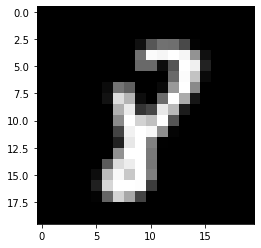

In [11]:
plt.imshow(X[3000].reshape(20,20).T,cmap='gray', vmin=0, vmax=1)
plt.show()

<Figure size 432x288 with 0 Axes>

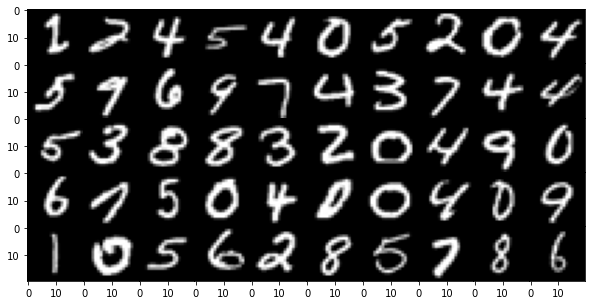

In [12]:
plt.figure()

gridrows = 5;
gridcolumns = 10;

gridsize = gridrows * gridcolumns;

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(gridrows, gridcolumns, gridspec_kw={'wspace': 0,'hspace':0}, sharex = True, sharey = True,
                        figsize=(gridcolumns, gridrows)) 

# use the created array to output your multiple images. In this case made a 10 x 10 grid of random images from data

for i in range(gridrows):
    for j in range(gridcolumns):
        axarr[i][j].imshow(X[int(numimages / gridsize)  * (gridcolumns* i + j)].reshape(20,20).T,
                           cmap='gray', vmin=0, vmax=1, aspect = 'auto')

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [14]:
def gradientdescent(X,Y, lmbda, alpha, hidlayerunits, maxiter):   # with regularization
    m = X.shape[0]
    numpixels = X.shape[1]
    numdigits = 10
    
    epsilon = 0.12
    
    Jiter = np.zeros(maxiter); 
    
    W1 = epsilon * np.random.uniform(-epsilon, epsilon, (hidlayerunits, numpixels))   # W1 is 25 by 400, X is 5000 by 400
    W2 = epsilon * np.random.uniform(-epsilon, epsilon, (numdigits, hidlayerunits))   # W2 is 10 by 25, X is 5000 by 400
    b1 = np.zeros((hidlayerunits, 1))           # b1 is 25 by 1, 1 real value for each hidden layer unit
    b2 = np.zeros((numdigits, 1))               # b2 is 10 by 1, 1 real value for each class
    
    A1 = X
    tic = time.time()
    for i in range (maxiter):        
        Z2 = A1  @ W1.T + b1.T   # Z2 is 5000 by 25
        A2 = sigmoid(Z2)        # A2 is 5000 by 25
        Z3 = A2 @ W2.T + b2.T   # Z3 is 5000 by 10
        A3 = sigmoid(Z3)        # 5000 by 10; the output, i.e. the prediction values for each class        
        
        d3 = A3 - Y # 5000 by 10
        d2 = (d3 @ W2) * A2 * (1 - A2); #5000 by 25
        
        Wdelta2 = d3.T @ A2  # 10 by 25
        Wdelta1 = d2.T @ A1  # 25 by 400       
        
        #Calculating Cost function at current iteration
        Jiter[i] = -(Y * np.log(A3) + (1 - Y) * np.log(1 - A3)).sum(axis = (1,0)) 
        Jiter[i] += lmbda / 2 * ((W1**2).sum(axis = (1,0)) + (W2**2).sum(axis = (1,0)))        
        Jiter[i] /= m  
        
        #Gradient Values
        db2 =  (1 / m * np.sum(d3, axis = 0, keepdims = 1)).T
        db1 =  (1 / m * np.sum(d2, axis = 0, keepdims = 1)).T
        W2D = 1 / m * (Wdelta2 + lmbda * W2)
        W1D = 1 / m * (Wdelta1 + lmbda * W1)
        
        W2 -= alpha * W2D
        W1 -= alpha * W1D
        b2 -= alpha * db2
        b1 -= alpha * db1
        
        clear_output(wait=True)
        print(f'Training Neural Network. Iteration number : {i + 1} / {maxiter}')
        print(f'Cost in current iteration : {"{:.3f}".format(Jiter[i])}')
        toc = time.time()
        print(f'Total time taken for training Neural Network : {"{:.1f}".format(toc-tic)} s')
        
    return [W1, W2 ,b1, b2, Jiter]    

In [15]:
#Calling the Gradient descent function to return optimized parameters and cost array
W1opt, W2opt, b1opt, b2opt, Jiter = gradientdescent(X, Yrecoded, maxiter = 1000, lmbda = 1, hidlayerunits = 25, alpha = 2)

Training Neural Network. Iteration number : 1000 / 1000
Cost in current iteration : 0.451
Total time taken for training Neural Network : 23.5 s


Final Cost = 0.4511974780221096


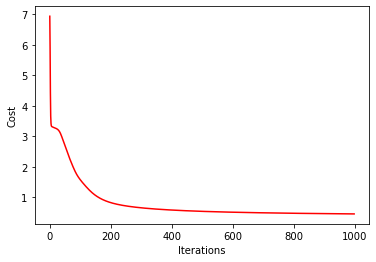

In [16]:
#Plotting cost function as a function of number of iterations of gradient descent

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.plot(Jiter[0:-1], 'r')

print(f'Final Cost = {Jiter[-1]}')

In [17]:
#Function for doing forward propagation and returning encoded predictions

def predict(X, W1, W2, b1, b2):
    Z2 = X  @ W1.T + b1.T   # Z2 is 5000 by 25
    A2 = sigmoid(Z2)        # A2 is 5000 by 25
    Z3 = A2 @ W2.T + b2.T   # Z1 is 5000 by 10
    Ypred = sigmoid(Z3)        # 5000 by 10 the output, i.e. the prediction values for each class

    Yencoded = np.argmax(Ypred, axis=1).reshape(X.shape[0],1)
    return Yencoded
    

In [18]:
#Forward propagation with optimized parameters

Yencoded = predict(X, W1opt, W2opt, b1opt, b2opt);
trainaccuracy = sum(Yencoded == Y)[0] / Y.shape[0] * 100
print(f'Training set accuracy = {trainaccuracy}')

Training set accuracy = 96.825


In [19]:
yn = 'Y'
while str.lower(yn) == 'y':
    imageid = random.randint(0,X.shape[0])
    plt.imshow(X[imageid].reshape(20,20).T,cmap='gray', vmin=0, vmax=1)
    plt.show()
    print(f'The prediction for the above picture is {Yencoded[imageid][0]}')
    print(f'The true label for the above picture is {Y[imageid][0]}')    
    clear_output(wait=True)
    yn = input('Do you want to see another one?(Y/N)')

Do you want to see another one?(Y/N)m


<Figure size 432x288 with 0 Axes>

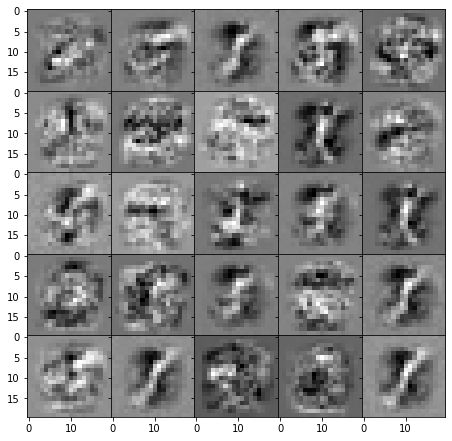

In [20]:
#Plotting the learned parameter W1opt; each picture corresponds to a unit in the hidden layer

plt.figure()

gridrows = int(np.ceil(W1opt.shape[0] / 5));
gridcolumns = 5;

gridsize = W1opt.shape[0];

#subplot(r,c) provides the no. of rows and columns
f, axarr = plt.subplots(gridrows,gridcolumns, sharex = True, sharey = True, figsize = (gridcolumns*1.5,gridrows*1.5),  
                        gridspec_kw={'wspace': 0,'hspace':0}) #to remove spaces between subplots

for i in range(gridsize):
        axarr[int(i/5)][i%5].imshow((W1opt)[i].reshape(20,20).T,cmap='gray', aspect = 'auto')

<Figure size 432x288 with 0 Axes>

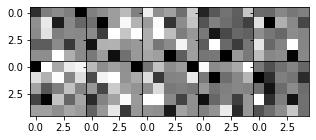

In [21]:
#Plotting the learned parameter W2

plt.figure()

gridrows = int(np.ceil(W2opt.shape[0] / 5));
gridcolumns = 5;

gridsize = W2opt.shape[0];

#subplot(r,c) provides the no. of rows and columns
f, axarr = plt.subplots(gridrows,gridcolumns, sharex = True, sharey = True ,figsize = (gridcolumns, gridrows),  
                        gridspec_kw={'wspace': 0,'hspace':0}) 

for i in range(gridsize):
        axarr[int(i/5)][i%5].imshow((W2opt)[i].reshape(5,-1),cmap='gray', aspect = 'auto')

<Figure size 432x288 with 0 Axes>

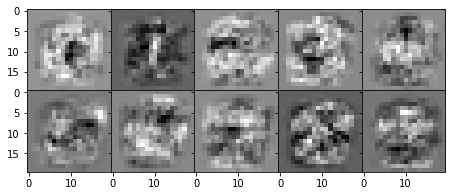

In [22]:
#Plotting the learned parameter W2@sigmoid(W1)
#observe the faint shapes of each digit in the images

plt.figure()

gridrows = int(np.ceil(W2opt.shape[0] / 5));
gridcolumns = 5;

gridsize = W2opt.shape[0];

#subplot(r,c) provides the no. of rows and columns
f, axarr = plt.subplots(gridrows,gridcolumns, sharex = True, sharey = True ,figsize = (gridcolumns*1.5, gridrows*1.5),  
                        gridspec_kw={'wspace': 0,'hspace':0}) 

for i in range(gridsize):
        axarr[int(i/5)][i%5].imshow((W2opt@sigmoid(W1opt))[i].reshape(20,20).T,cmap='gray', aspect = 'auto')

In [23]:
#Checking Test Set accuracy
Yencodedtest = predict(Xtest, W1opt, W2opt, b1opt, b2opt);
testaccuracy = sum(Yencodedtest == Ytest)[0] / Ytest.shape[0] * 100
print(f'Test set accuracy = {testaccuracy}')

Test set accuracy = 91.0


In [24]:
yn = 'Y'
while str.lower(yn) == 'y':
    imageid = random.randint(0,Xtest.shape[0])
    plt.imshow(Xtest[imageid].reshape(20,20).T,cmap='gray', vmin=0, vmax=1)
    plt.show()
    print(f'The prediction for the above picture is {Yencodedtest[imageid][0]}')
    print(f'The true label for the above picture is {Ytest[imageid][0]}')    
    clear_output(wait=True)
    yn = input('Do you want to see another one?(Y/N)')

Do you want to see another one?(Y/N)n
